In [1]:
import numpy as np
import pandas as pd

# 去标识
adult = pd.read_csv('adult_with_pii.csv')
adult_data = adult.copy().drop(columns=['Name', 'SSN'])
adult_pii = adult[['Name', 'SSN', 'DOB', 'Zip']]
adult_data.head(1)

,DOB,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,9/7/1967,64152,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56,2174,0


## K-匿名性
把数据集按照数据集各个列中的特定子集分组，即按照准标识（Quasi-Identifier）分组，使每个分组中的个体都拥有相同的准标识。如果数据集中的每个个体所属分组的大小都至少为则我们称此数据集满足k-匿名性

In [2]:
raw_data = {
    'first_name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy'], 
    'last_name': ['Miller', 'Jacobson', 'Ali', 'Milner', 'Cooze'], 
    'age': [42, 52, 36, 24, 73], 
    'preTestScore': [4, 24, 31, 2, 3],
    'postTestScore': [25, 94, 57, 62, 70]}
#df = pd.DataFrame(raw_data, columns = ['first_name', 'last_name', 'age', 'preTestScore', 'postTestScore'])
df = pd.DataFrame(raw_data, columns = ['age', 'preTestScore', 'postTestScore'])
df

,age,preTestScore,postTestScore
0,42,4,25
1,52,24,94
2,36,31,57
3,24,2,62
4,73,3,70


In [3]:
def isKAnonymized(df, k):
    for index, row in df.iterrows():
        query = ' & '.join([f'{col} == {row[col]}' for col in df.columns])
        rows = df.query(query)
        if rows.shape[0] < k:
            return False
    return True

In [4]:
isKAnonymized(df, 1)

True

## 泛化数据以满足k-匿名性

In [5]:
def generalize(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))

现在，我们可以对示例数据帧进行泛化处理了。首先，我们尝试对每一列数据进行”一层”泛化，即四舍五入到十位。

In [6]:
depths = {
    'age': 1,
    'preTestScore': 1,
    'postTestScore': 1
}
df2 = generalize(df, depths)
df2

,age,preTestScore,postTestScore
0,40,0,20
1,50,20,90
2,30,30,50
3,20,0,60
4,70,0,70


注意，即使经过了泛化，我们的示例数据仍然无法满足k=2下的k-匿名性。

In [7]:
isKAnonymized(df2, 2)

False

我们可以尝试对数据进一步泛化，但我们最终将会删除所有数据！

In [8]:
depths = {
    'age': 2,
    'preTestScore': 2,
    'postTestScore': 2
}
generalize(df, depths)

,age,preTestScore,postTestScore
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


### 引入更多的数据

In [9]:
df = adult_data[['Age', 'Education-Num']]
df.columns = ['age', 'edu']
isKAnonymized(df.head(100), 1)

True

此时泛化数据

In [10]:
# outliers are a real problem!
depths = {
    'age': 1,
    'edu': 1
}
df2 = generalize(df.head(1000), depths)
isKAnonymized(df2, 2)

False

<Axes: >

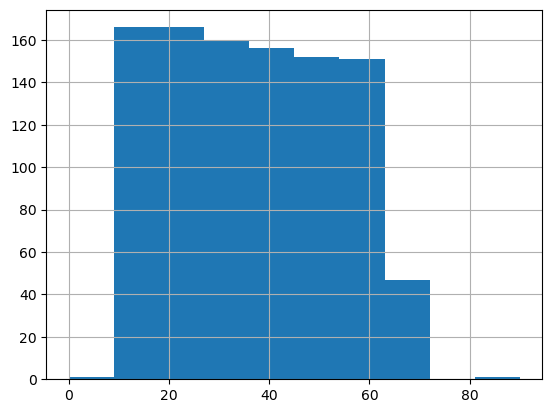

In [11]:
df2['age'].hist()

## 移除异常值

In [12]:
# 裁剪异常值
depths = {
    'age': 1,
    'edu': 1
}
dfp = df.clip(upper=np.array([60, 10000000000000]), axis='columns')
df2 = generalize(dfp.head(500), depths)
isKAnonymized(df2, 7)

False

## 差分隐私

tip:在差分隐私（Differential Privacy）中，隐私消耗量是一个指标，用于衡量在保护数据隐私的同时引入的噪声或者额外的隐私保护措施。它通常用 ε（epsilon）来表示。

隐私消耗量ε的值越小，表示引入的噪声或者隐私保护程度越高，数据的隐私得到了更好的保护。而ε的值越大，表示隐私保护程度越低，因为引入的噪声较少，可能泄露更多关于原始数据的信息。

在差分隐私中，ε可以用来衡量两个相邻数据集之间的差异，即对于任何一个可能的数据集，通过差分隐私机制发布的结果与在该数据集上发布结果之间的隐私损失。常见的情况是，当ε较小时，数据隐私受到更严格的保护，但数据分析的效用可能会受到影响；而当ε较大时，数据的可用性和分析效用可能会增加，但隐私保护程度会降低。

因此，隐私消耗量是在差分隐私中平衡数据隐私保护和数据分析效用之间的重要参数。

In [13]:
sensitivity = 1
epsilon = 0.1

adult = adult_data
adult.head()

,DOB,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,9/7/1967,64152,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56,2174,0
1,6/7/1988,61523,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,35,0,0
2,8/6/1991,95668,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,32,0,0
3,4/6/2009,25503,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,14,0,0
4,9/16/1951,75387,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,72,0,0


In [14]:
adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

17448.524171518984

# 差分隐私的性质
## 串行组合性

In [15]:
import matplotlib.pyplot as plt
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2

# 满足1-差分隐私
def F1():
    return np.random.laplace(loc=0, scale=1/epsilon1)

# 满足1-差分隐私
def F2():
    return np.random.laplace(loc=0, scale=1/epsilon2)

# 满足2-差分隐私
def F3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)

# 根据串行组合性，满足2-差分隐私
def F_combined():
    return (F1() + F2()) / 2

输出结果分布越尖锐（即更集中在某个取值附近），意味着数据的隐私保护程度越低，因为攻击者可以更准确地推断出原始数据的可能取值。

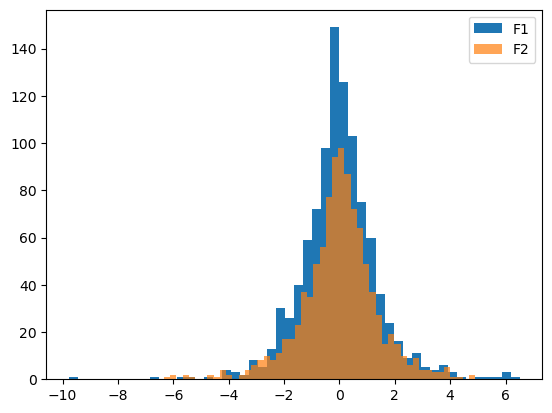

In [16]:
# 绘制F1
plt.hist([F1() for _ in range(1000)], bins=50, label='F1')

# 绘制F2（看起来应该与F1相同）
plt.hist([F2() for _ in range(1000)], bins=50, alpha=.7, label='F2')
plt.legend();

我们绘制出F1和F3的输出概率分布图。可以看出，F3的输出概率分布看起来比F1的更”尖”，这是因为
取值越大意味着隐私保护程度越低，因此输出结果远离真实结果的可能性也就越小。

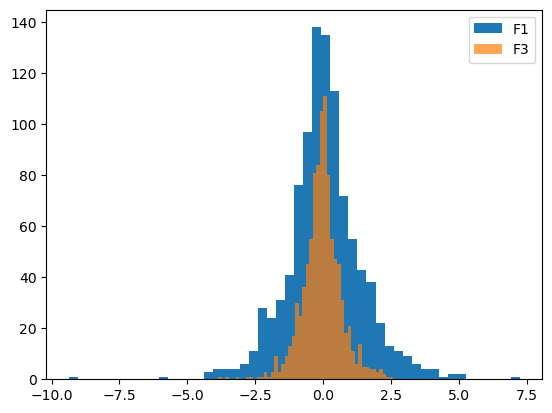

In [17]:
# 绘制F1
plt.hist([F1() for _ in range(1000)], bins=50, label='F1')

# 绘制F3（看起来应该比F1更"尖"）
plt.hist([F3() for _ in range(1000)], bins=50, alpha=.7, label='F3')
plt.legend();

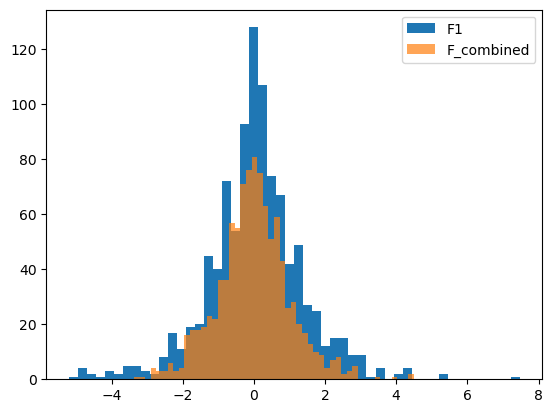

In [18]:
# 绘制F1
plt.hist([F1() for _ in range(1000)], bins=50, label='F1')

# 绘制F_combined（看起来应该比F1更"尖"）
plt.hist([F_combined() for _ in range(1000)], bins=50, alpha=.7, label='F_combined')
plt.legend();

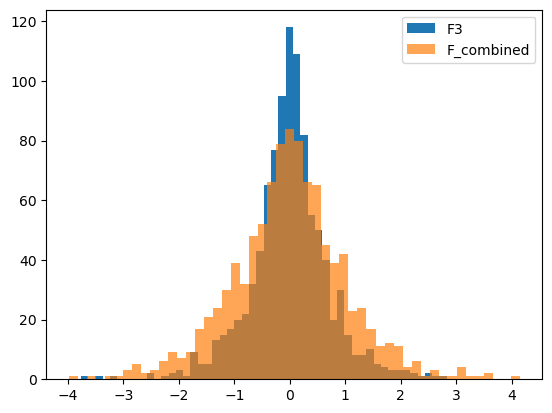

In [19]:
# 绘制F3
plt.hist([F3() for _ in range(1000)], bins=50, label='F3')

# 绘制F_combined（看起来应该与F3相同）
plt.hist([F_combined() for _ in range(1000)], bins=50, alpha=.7, label='F_combined')
plt.legend();

串行组合性给出了多次发布后总ε的上界，实际发布的累积隐私消耗量可能会更低一些，所以F3尖一些，而F_combined平一些
当控制总隐私消耗量时，串行组合性是一个极为有用的方法

## 并行组合性
把数据集划分为k个子数据块，并在k个子数据块上分别应用相同的差分隐私机制（这意味着我们在数据集上应用了k次差分隐私机制），我们再每个个体数据上仅使用了一次差分隐私机制

### 直方图

In [20]:
adult = pd.read_csv("adult_with_pii.csv")
adult['Education'].value_counts().to_frame().head(5)

,count
Education,
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1383


In [21]:
epsilon = 1

# 虽然我们发布了多个结果，但此次数据分析的总隐私消耗量为ε = 1
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,count
Education,
HS-grad,10500.171101
Some-college,7290.224007
Bachelors,5354.904618
Masters,1723.866458
Assoc-voc,1381.338365


### 列联表

In [22]:
pd.crosstab(adult['Education'], adult['Sex']).head(5)

Sex,Female,Male
Education,,
10th,295,638
11th,432,743
12th,144,289
1st-4th,46,122
5th-6th,84,249


In [23]:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
ct.applymap(f).head(5)

C:\Users\administrat\AppData\Local\Temp\ipykernel_11740\3751694223.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ct.applymap(f).head(5)


Sex,Female,Male
Education,,
10th,297.284807,638.468170
11th,432.429835,743.172088
12th,143.374152,290.430303
1st-4th,46.053111,121.145131
5th-6th,84.115560,249.267380


## 后处理性

差分隐私的后处理性保证了在已经对数据进行差分隐私保护的前提下，可以进行额外的操作，如数据分析、查询或计算等，而不会破坏差分隐私的保护效果。
当使用差分隐私机制对数据进行处理后，确保在处理后的数据上进行的任何后续操作不会进一步泄露个体隐私信息是非常重要的

In [24]:
# 差分隐私机制示例：向每个数据点添加 Laplace 噪声
def add_noise(data, epsilon):
    # 计算每个数据点添加的噪声大小
    scale = 1.0 / epsilon
    
    # 添加 Laplace 噪声
    noisy_data = data + np.random.laplace(loc=0.0, scale=scale, size=data.shape)
    
    return noisy_data

# 示例数据集
data = np.array([1, 2, 3, 4, 5])

# 差分隐私参数
epsilon = 0.5

# 对数据应用差分隐私机制
noisy_data = add_noise(data, epsilon)

# 后处理操作示例：计算平均值
def compute_mean(data):
    return np.mean(data)

# 对添加了噪声的数据进行后处理操作
mean = compute_mean(noisy_data)

# 输出结果
print("原始数据：", data)
print("添加噪声后的数据：", noisy_data)
print("计算的平均值（后处理）：", mean)

原始数据： [1 2 3 4 5]
添加噪声后的数据： [ 5.11621364  2.58918895  4.431855   -1.14427153  5.50341697]
计算的平均值（后处理）： 3.2992806034222824
